In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import glob
import pandas as pd
from scipy.optimize import curve_fit

Loading the two flat images and two bias frames I'm gonna use.

In [22]:
flat1 = fits.getdata("./CCD data/Flat 24_sec.FIT").astype(np.int32)
flat2 = fits.getdata("./CCD data/Flat 30_sec.FIT").astype(np.int32)
bias1 = fits.getdata("./CCD data/bias1.FIT").astype(np.int32)
bias2 = fits.getdata("./CCD data/bias2.FIT").astype(np.int32)
print(flat1.shape)

(1472, 2184)


For a specific subregion, we get the mean values for the flatfield frames and the bias frames and the standard deviation of the image difference/

In [23]:
row0 = 500
row1 = 600
colm0 = 300
colm1 = 400

sub_mean_f1 = np.mean(flat1[row0:row1, colm0:colm1])
print(sub_mean_f1)

sub_mean_f2 = np.mean(flat2[row0:row1, colm0:colm1])
print(sub_mean_f2)

sub_mean_b1 = np.mean(bias1[row0:row1, colm0:colm1])
print(sub_mean_b1)

sub_mean_b2 = np.mean(bias2[row0:row1, colm0:colm1])
print(sub_mean_b2)

sub_sigma_f1f2 = np.std(flat1[row0:row1, colm0:colm1] - flat2[row0:row1, colm0:colm1] )
print(sub_sigma_f1f2)

sub_sigma_b1b2 = np.std(bias1[row0:row1, colm0:colm1] - bias2[row0:row1, colm0:colm1] )
print(sub_sigma_b1b2)

36478.2872
45093.469
1155.2103
1155.5823
256.41146103238054
19.108862237192458


Get the gain value for the subregion.

In [24]:
sub_gain =  ((sub_mean_f1 + sub_mean_f2) - (sub_mean_b1 + sub_mean_b2)) / (sub_sigma_f1f2**2 - sub_sigma_b1b2**2 )
print(sub_gain)

1.212280764480861


Read Noise in two units for the subregion

In [25]:
# in electrons
sub_read_noise = sub_gain * sub_sigma_b1b2/ np.sqrt(2)
print(sub_read_noise)

# in ADUs
sigma_read_noise = sub_read_noise / sub_gain 
print(sigma_read_noise)

16.380345046607395
13.512006068678327


For the linearity

In [20]:
flat_list = glob.glob('./CCD data/Flat*.FIT')
print(flat_list)

['./CCD data/Flat_75_sec.FIT', './CCD data/Flat 30_sec.FIT', './CCD data/Flat 42_sec.FIT', './CCD data/Flat 6_sec.FIT', './CCD data/Flat 48_sec.FIT', './CCD data/Flat 54_sec.FIT', './CCD data/Flat 36_sec.FIT', './CCD data/Flat 1.5_sec.FIT', './CCD data/Flat_375_sec.FIT', './CCD data/Flat 3_sec.FIT', './CCD data/Flat 24_sec.FIT', './CCD data/Flat_185_sec.FIT', './CCD data/Flat 18_sec2.FIT', './CCD data/Flat 60_sec.FIT', './CCD data/Flat 12_sec.FIT']


In [21]:
exp_times = []
means = []

for filename in flat_list:

    hdu = fits.open(filename)
    
    exptime = hdu[0].header['exptime']
    print('Exposure time {} sec'.format(exptime))
    exp_times.append(exptime)
    
    mean_counts = np.mean(hdu[0].data)
    print('Mean counts: {:.2f}\n'.format(mean_counts))
    means.append(mean_counts)

exp_times = np.array(exp_times)
means = np.array(means)

time_sort = np.argsort(exp_times)
exp_times = exp_times[time_sort]
means = means[time_sort]

Exposure time 0.75 sec
Mean counts: 2192.44

Exposure time 30.0 sec
Mean counts: 45259.31

Exposure time 42.0 sec
Mean counts: 56429.01

Exposure time 6.0 sec
Mean counts: 9578.54

Exposure time 48.0 sec
Mean counts: 57330.16

Exposure time 54.0 sec
Mean counts: 57626.20

Exposure time 36.0 sec
Mean counts: 52164.65

Exposure time 1.5 sec
Mean counts: 3174.87

Exposure time 0.375 sec
Mean counts: 1673.31

Exposure time 3.0 sec
Mean counts: 5353.18

Exposure time 24.0 sec
Mean counts: 36629.32

Exposure time 0.185 sec
Mean counts: 1413.65

Exposure time 18.0 sec
Mean counts: 26611.05

Exposure time 60.0 sec
Mean counts: 57723.53

Exposure time 12.0 sec
Mean counts: 18178.72



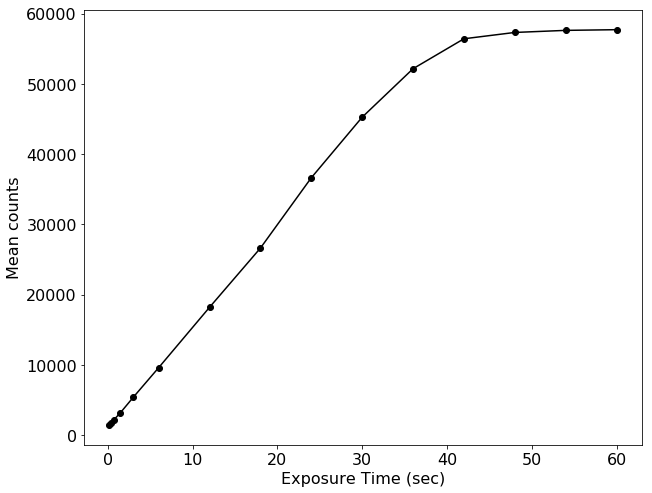

In [193]:
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 16

plt.plot(exp_times, means, '-ko')
plt.xlabel('Exposure Time (sec)')
plt.ylabel('Mean counts')
plt.show()

For the dark current and band gap energy

In [194]:
t_cel = np.array([-15., -10., -8., -6., -4.2, -2.3, 0., 2., 
                3.6, 5.8, 8.2, 10., 12.8, 16.2, 20.])
adu = np.array([13, 15, 16, 17, 19, 22, 24, 28, 32, 37, 
                43, 50, 62, 89, 139])

In [204]:
#Convert Celsius to Kelvin
t_kel = t_cel + 273.15

In [205]:
#Convert ADU (counts) to electrons，based on the gain 2.3 e-/ADU
electrons = 2.3 * adu

In [210]:
#Convert electrons to electrons per second due to the 2 minute exposures
electrons_per_sec = electrons/ (2*60)

array([0.24916667, 0.2875    , 0.30666667, 0.32583333, 0.36416667,
       0.42166667, 0.46      , 0.53666667, 0.61333333, 0.70916667,
       0.82416667, 0.95833333, 1.18833333, 1.70583333, 2.66416667])

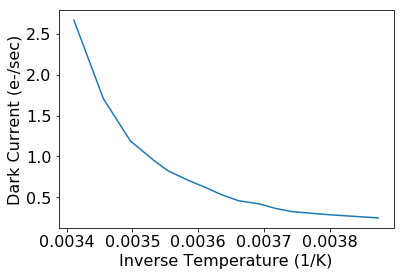

In [213]:
plt.xlabel('Inverse Temperature (1/K)')
plt.ylabel('Dark Current (e-/sec)')
plt.plot(1/t_kel, electrons_per_sec)

# We will try to fit a model for dark current of the form

$D =  \alpha e^{-e_g/2k_bT}$

In [219]:
# The Boltzmann constant
k_b = 8.6175e-5
def dark_current(t_k, alpha, e_g):
    """
    Analytic expression for dark current as a function of temperature.
    
    Parameters
    ----------
    t_k : numpy.ndarray
        Temperature in Kelvin
    alpha : float
        Constant coefficient in front of exponential funtion.
    e_g : float
        Band gap energy in eV.
    
    Returns
    -------
    dark_current : numpy.ndarray
        Dark current in electrons/pixel/second.
    """
    dark_current = alpha * np.exp(-e_g / (2 * k_b * t_k))
    return dark_current

In [220]:
# Initial guesses
t_0 = t_kel[-1]
d_0 = electrons_per_sec[-1]

alpha_0 =  d_0 / np.exp(-1.1 / (2 * k_b * t_0))
e_g_0 = 1.1

In [221]:
# Least squares fit
p_opt, p_cov = curve_fit(dark_current, t_kel, electrons_per_sec, p0=[alpha_0, e_g_0])

# Errors in the fit
sig_alpha, sig_e_g = np.sqrt(np.diag(p_cov))

In [222]:
# Best fit
alpha_fit, e_g_fit = p_opt
print(alpha_fit)
print(e_g_fit)

77098910165.43013
1.2205226843061665
